# Chapter 8: Dimensionality Reduction

- Reducing dimensionality causes some information to be lost but can speed up training
- Reducing dimensionality can be useful for data visualization

# 1. The Curse of Dimensionality

In high dimension, there is plently of space. This means that two points can be very far apart even though they both lie within the same unit hypercube.
- High dimensional datasets are at risk of being very sparse. Most training instances are likely to be far away from each other.
- This means that new instance will likely be far away from any training instance, making predictions less reliable than in lower dimensions.
- As a result, more dimensions the training set has, the greater the risk of overfitting it

![cod](images/curse_of_dimensionality.jpg)

https://www.youtube.com/watch?v=DyxQUHz4jWg

![cod](images/cod.png)

# 2. Main Approaches for Dimensionality Reduction

## 2.1 Projection

Training instances are not spread out uniformly. Features sometimes are highly corelated. As a result, all training instances lie within a much lower-dimensional subspace of the high-dimensional space. i.e, there exist a lower dimensional subspace inside the higher dimensional subspace

![figure8.2](images/figure8.2.png)

All training instances in the above image lie close to a plane. This is the lower-dimensional (2D) subspace of the higher-dimensional (3D)

![figure8.3](images/figure8.3.png)

If we project every training instances perpendicularly onto this subspace, we get the new 2D dataset as shown above.

## 2.2 Manifold Learning

Project may not always be the best approach to dimensionality reduction as there are cases where the subspace may twist and turn (swiss roll)

![figure8.4](images/figure8.4.png)

If we project the subspace onto a plane, we would squash the different layers of the swiss roll together which is not what we want.

![figure8.5](images/figure8.5.png)

The swiss role is an example of a 2D manifold.  
- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space.
- More generally, a d-dimensional manifold is a part of an n-dimensional space (d < n) that locally resembles a d dimensional hyperplane. 
- For the swiss role example, d=2 and n=3.

**Manifold Learning**: Modeling the manifold on which the training instances lie.
- Relies on the manifold assumption/hypothesis which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.

# 3. Algorithms

## 3.1 Principal Component Analysis (PCA)

- First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### How do we choose the hyperplane?

![figure8.7](images/figure8.7.png)

- For example, a simple 2D dataset is represented on the left, along with three different 1D axes.
- On the right is the result of the projection of the dataset onto each of these axes.
- The projection onto the solid line preseves the maximum variance as compared to the other 2 lines
- As such, it is reasonable to select the axis that **preserves the maximum amount of variance** as it will most likely lose less information than the other projections.
- It is also the axis that **minimizes the mean squared distance** between the original dataset and its projection onto that axis.

### Principal Components (PC)

- PCA identifies the axis that accounts for the largest amount of variance in the training set. (c1)
- It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. (c2)
- For higher-dimensional data, PCA would also find the third axis, orthogonal to the previous axes and a fourth, fifth so on.
- The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data
- For each PC, PCA finds a zero-centered unit vector pointing in the direction of the PC.
- PCA assumes that the dataset is centered around the origin. Scikit-Learn's PCA classes take care of centering the data for us.

### How to find the PCs of a training set?

Using a matrix factorization technique called Singular Value Decomposition (SVD).
- SVD can decompose the training set matrix X into the matrix multiplication of three matrices $U \sum V^{T}$ where $V$ contains the unit vectors that define all the PCs that we are looking for.

![v](images/v.png)

In [4]:
import numpy as np
m = 200

X = np.random.randn(m, 2) / 10
X_centered = X - X.mean(axis=0) # centering
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]


Once identified all the PCs, we can reduce dimension to d dimensions by projecting it onto the hyperplane defined by the first d principal components. 

To obtain a reduced dataset $X_{d-proj}$ of dimensionality d, we multiple the training set matrix $X$ by the matrix $W_{d}$ which is the matrix containing first *d* columns of $V$    

![equation8.2](images/equation8.2.png)

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

### How many PCs to use?

In [8]:
pca.explained_variance_ratio_

array([0.51190961, 0.48809039])

51% of the dataset's variance lies along the first PC and 48% lies along the second PC.

In [10]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [11]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

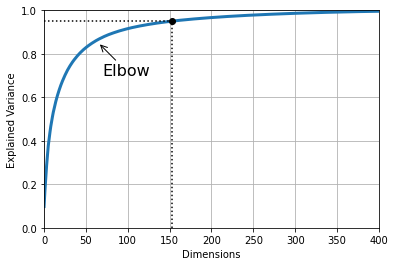

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [15]:
d

153

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
pca.n_components_

153

In [18]:
np.sum(pca.explained_variance_ratio_)

0.950004265741372

### PCA for Commpression

- By reducing dimension from 784 to just over 150 features, while most of the variance is preserved, the dataset is not less than 20% of the original size and this is a resonable compression ratio.
- We can also decompress the dataset back to 784 dimensions by applying inverse transformation of the PCA projection but we wont get back the original dataset since the projection lost a bit of information. But it will likely still be close to the original data.

In [19]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

![equation8.3](images/equation8.3.png)